In [3]:
#importing all possibly relevant packages
import IPython
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import sklearn.metrics.pairwise as pair
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA, KernelPCA
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import svm
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [4]:
# Function to return the auc values for each class
def aucfun(clf, X_test, Y_test):    
    y_bin = label_binarize(Y_test, classes=[1, 2, 3, 4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    Y_predict = clf.predict_proba(X_test)    
    #Calculate AUC
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], Y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    return roc_auc

In [5]:
# Import training data and labels into dataframes
X = pd.read_csv('trainingData.txt', sep='\t', header = None)
Y = pd.read_csv('trainingTruth.txt', sep='\t', header = None)
Y = np.array(Y).ravel()

**The first thing we did was realize that the baseline script was training and testing both on 100% of the training data set; we decided to start splitting the data set into training and testing subsets so that we could get a better sense for how the classifiers would ultimately perform on test data. Here we first try to run the data using the base RandomForest classifier again on our split dataset.**

In [14]:
#fill NaN's with zeros
X_zeros = X.fillna(0)
#split dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_zeros, Y, test_size=0.20, random_state=25)

#We commented this code out because OneVsRestClassifier is causing a bizarre error to appear.  This is the baseline code. 
#clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 2, random_state=25))
#clf.fit(X_train, Y_train)
#print(clf.score(X_test, Y_test))
#print(aucfun(clf, X_test, Y_test))

0.569332566168
{0: 0.86014548202186658, 1: 0.71242058510233586, 2: 0.85638518053498403, 3: 0.59322531535450196}


**We then played with the parameter settings manually to see how much we could gain in accuracy without yet directly manipulating the data. Just doing that we saw below a gain of about 10% in prediction accuracy.**

In [16]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, random_state=25, criterion='entropy',
                                                max_features='auto', min_impurity_split = 1e-6))

clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))

0.661392405063
{0: 0.94674890063842565, 1: 0.81848013200943459, 2: 0.93385955447438374, 3: 0.70579568756602251}


**We then came up with two ideas on how to better deal with the missing values in the data. First, we thought about calculating the correlation coefficient between every pair of features for all examples within a certain class;
the idea being that when we have NaN's, we can look at the feature that most strongly correlates with the feature whose values we're missing, build a regression model based on that coefficient and predict our missing values using that model.  Below, we calculate a correlation matrix for all features.**

In [23]:
#create dataframe with class labels included
X_withclasses = X.copy()
X_withclasses['class'] = Y

In [24]:
'''This function gives us a list of correlation matrices for all feature pairs for each class'''
def feat_corr():
    corrs = []
    for i in range(4):
        classi = X_withclasses.loc[X_withclasses['class'] == i + 1]        
        classi = classi.drop('class', 1)        
        corrs.append(classi.corr(method = 'pearson'))        
    return corrs

#get correlation matrix for each pair of features for each class
corrs = feat_corr()

#fill diagonal values with 0 since all of them are 1 in a correlation matrix
for i in corrs:
    np.fill_diagonal(i.values, 0)

In [31]:
'''Finds the highest absolute value correlation coefficient between all pairs of features for a certain class'''  
def max_corr(corrs):
    return [np.absolute(i).max().max() for i in corrs]
maxes = max_corr(corrs)    
print(maxes)

[0.24997305653985449, 0.13750980947766309, 0.1903504295059652, 0.14457949316609414]


**Above, we show the highest correlation values for each class.  We can see that even the highest correlation coefficient (we look at negative coefficients too in the form of absolute values) between any pair of features within a class is extremely low, indicating that none of the features has any significant linear relationship with any other feature.**

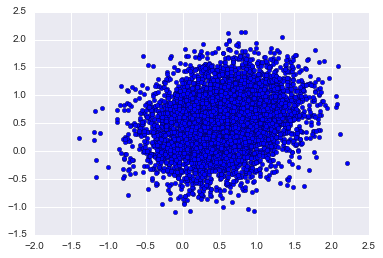

In [59]:
#find highest correlation coefficient to graph features
max_feature = corrs[0].as_matrix()
arg = max_feature.argmax()
row, col = (arg//max_feature.shape[1], arg%max_feature.shape[1])

#get features correlation matrix for class 1
class1 = X_withclasses.loc[X_withclasses['class'] == 1]
class1 = class1.drop('class', 1)
corr1 = np.array(class1.corr(method = 'pearson'))

#plot feature vs feature to get any idea of what is going on 
plt.scatter(class1[row], class1[col])
plt.show()


**Above we see that even the two features with the highest correlation coefficient in all 4 classes do not share a strong enough linear, or seemingly other, relationship to be used effectively for prediction.**

**Having discovered that we could not fill NaNs using the feature correlation idea, we came up with a second idea to address NaNs: We decided to fill NaNs by finding the row at the shortest Euclidean distance, and then using that row's corresponding feature values to populate the NaNs of the row with missing values.   
We realized that comparing row pairwise distances was problematic because each pair could be missing a different number of dimensions. To remedy the problem, we decided to fill in the NaNs with zeros before computing distance, reasoning that given the distribution of the number of missing values within the examples (maximum 7 missing values), doing this was unlikely to have any significant impact on what the closest neighbors would turn out to be.
One subtlety of our implementation is that in the case in which the closest vector is missing the same values as the vector whose NaN values we're trying to fill, we sort the distance matrix (only in this case since it is an expensive operation) and look at the second, third, etc...closest vectors, until we find the closest one that also contains numerical values for the corresponding NaN values in the original vector.**

In [62]:
#Helper function to replace_nans_nn
def replace_nans_nn_helper(X):
    #Create a matrix of pairwise distances between all of the points
    dist = pair.pairwise_distances(X.fillna(value=0))
    np.fill_diagonal(dist, np.NaN)
    #Create an array of nearest neighbors for each row
    closest = np.nanargmin(dist, axis = 1)
    #Loop through the data and replace NaN's with nearest neighbors
    for i in range(X.shape[1]):
        for j in range(X.shape[0]):
            if np.isnan(X[i][j]):
                if not np.isnan(X[i][closest[j]]):
                    X[i][j] = X[i][closest[j]]
                else:
                    X[i][j] = X[i][np.argsort(dist[j])[1]]
    return X

#Function to replace the NaN values with the corresponding feature from the nearest neighbor datapoint
def replace_nans_nn(X,Y):
    #Separate the data by class
    Xdivided = {1: X.iloc[Y==1].reset_index(drop=True), 2: X.iloc[Y==2].reset_index(drop=True), \
            3: X.iloc[Y==3].reset_index(drop=True), 4: X.iloc[Y==4].reset_index(drop=True)}
    #Replace the NaNs in each separated dataframe with nearest neighbor feature values and concatenate the dataframes
    Xnew = pd.DataFrame()
    for i in Xdivided:
        Xdivided[i] = replace_nans_nn_helper(Xdivided[i])
        Xnew = pd.concat([Xnew,Xdivided[i]], ignore_index=True)
    #Add the label sorted column
    Y = np.sort(Y)
    return Xnew, Y

# Create the new datasets with NaNs populated according to the Euclidean distance method
X_dist, Y_sorted = replace_nans_nn(X,Y)

In [63]:
# Check the classification performance using the new dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_dist, Y_sorted, test_size=0.20, random_state=25)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))

0.665995397008
{0: 0.94222793584212039, 1: 0.82105054185351267, 2: 0.93616419626364955, 3: 0.69799266716935926}


**The classification results are roughly the same as they were when we simply replaced the NaNs with zeros. We decided to try a third method for replacing NaNs:  We replaced them with the feature mean for rows within the same class.**

In [6]:
# Divide the data into classes and populate the NaNs using the within class feature means. 
classes = [X.iloc[np.array(Y == i+1)] for i in range(4)]
classes = [i.apply(lambda x: x.fillna(x.mean()),axis=0) for i in classes]
X_mean = pd.concat(classes)
Y_sorted = np.sort(Y)

In [67]:
# Check the classification performance using the new dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_mean, Y_sorted, test_size=0.20, random_state=25)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))

0.672324510932
{0: 0.94777607184931689, 1: 0.82420870702541116, 2: 0.93647402512516575, 3: 0.70287158744880029}


**We can see here that the class mean method for filling NaNs seems to provide superior accuracy to our previous more complex and time consuming correlation and Euclidean distance methods for replacing NaNs. We then decided to look at how many rows were missing values and how many they were missing, and came up with one more way to deal with NaNs.**

In [72]:
#get number of rows for each possible number of missing features within dataset
nulls = X.isnull().sum(axis=1).tolist()
Counter(nulls)

Counter({0: 5759, 1: 6355, 2: 3517, 3: 1319, 4: 348, 5: 70, 6: 9, 7: 1})

**Looking above at the results of the count of rows for each possible number of missing values within our dataset,
we came up with one last strategy to deal with NaNs, which was to remove the rows with 4 or more missing values, which effectively would remove only 2-3% of the rows in our dataset.**

In [75]:
# Create a dataset without rows that contain more than 3 missing values
indices = np.array(X.isnull().sum(axis=1) < 4)
X_nan_limit = X.iloc[indices].reset_index(drop=True)
Y_nan_limit = Y[indices]

# Divide the data into classes and populate the NaNs using the within class feature means. 
classes = [X_nan_limit.iloc[np.array(Y_nan_limit == i+1)] for i in range(4)]
classes = [i.apply(lambda x: x.fillna(x.mean()),axis=0) for i in classes]
X_nan_limit = pd.concat(classes)
Y_nan_limit_sorted = np.sort(Y_nan_limit)

In [76]:
# Check the classification performance using the new dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_nan_limit, Y_nan_limit_sorted, test_size=0.20, random_state=25)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))

0.671386430678
{0: 0.94896770767778493, 1: 0.81372207920420592, 2: 0.93774760216847386, 3: 0.70967207556240741}


**Despite small differences between all of those methods, our mean_per_class method is still the highest performing of all and therfore the one we ended up using throughout the rest of our exploration process.**

**At this point, we wanted to start exploring other classifiers and other classification methods, so we decided to standardize our dataset, which while not making any difference for algorithms such as RandomForests, is important for classifiers such as Neural Networks and Support Vector Machines and will facilitate dimensionality reduction techniques such as PCA and LDA later on.**

In [7]:
# Standardize the data to have mean zero and unit variance
scaler = preprocessing.StandardScaler().fit(X_mean)
X = pd.DataFrame(scaler.transform(X_mean))
Y = Y_sorted

**We next wanted to test whether balancing classes to have the same number of rows per class would have a positive effect on performance. We took the class with the least number of rows and randomly extracted an equal number of rows from every other class before turning all of those subsets into a new balanced dataset.**

In [96]:
# Divide the data into classes and populate the NaNs using the within class feature means. 
classes = [X.iloc[np.array(Y == i+1)] for i in range(4)]
classes = [i.apply(lambda x: x.fillna(x.mean()),axis=0) for i in classes]
X_mean = pd.concat(classes)
Y_sorted = np.sort(Y)

X_balanced = X.copy()
X_balanced['class'] = Y

class1 = X_balanced.loc[X_balanced['class'] == 1]
class2 = X_balanced.loc[X_balanced['class'] == 2]
class3 = X_balanced.loc[X_balanced['class'] == 3]
class4 = X_balanced.loc[X_balanced['class'] == 4]

classes = [class1, class2, class3, class4]

#balance classes 
balclasses = [i.sample(classes[3].shape[0]) for i in classes]

X_balanced = pd.concat(balclasses)
Y_balanced = X_balanced['class']
X_balanced = X_balanced.drop('class', 1)


X_train, X_test, Y_train, Y_test = train_test_split(X_balanced, Y_balanced, test_size=0.20, random_state=25)

In [97]:
#test balanced dataset with RF
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50, random_state=25, criterion='entropy',
                                                max_features='auto', min_impurity_split = 1e-6))
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))

0.642960115329
{0: 0.93526649029813613, 1: 0.77101316911757134, 2: 0.9137730789913957, 3: 0.70848548519538224}


**We can see that the drop in performance is significant (~4%) compared to using the full dataset.** 

**Our hand-tuned multi-layer Perceptron Neural Network turned out to be the single highest performing classifier on the entire data set. Given how time consuming running the more complex models turned out to be, we initially in the first part of our exploration resorted mostly to hand-tuning the classifiers through trial and error, and common sense.**

In [87]:
def MLPclf():
    return MLPClassifier(solver='sgd', alpha=10, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=1000, 
                    activation = 'identity', learning_rate_init=0.001, momentum=0.9)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=25)

clf = MLPclf()
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))

0.770713463751
{0: 0.9710276833462067, 1: 0.90908211883408074, 2: 0.96422296145839548, 3: 0.85577693586991666}


**At this point, before delving into ensemble methods we felt it would be important to look into dimensionality reduction techniques to reduce the feature space, allowing us from a practical perspective to train models faster and therefore tune parameters more efficiently, while also potentially improving performance. Below we create datasets based on different dimensionality reduction techniques.**

In [8]:
# First we shuffle our full sized dataset
shuffled = np.random.permutation(X.index)
X = X.reindex(shuffled)
Y = Y[shuffled]

# Function to look for combination of most important features from each class
def get_imp_features(X,Y):
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators = 30, criterion='entropy', 
                                                     max_features='auto'))
    clf.fit(X,Y)
    return np.unique([[x[1] for x in sorted(zip(i.feature_importances_, X.columns), reverse=True)[0:5]] 
              for i in clf.estimators_])

# Create a reduced dimensionality dataset with SVD
svd = TruncatedSVD(n_components=30, algorithm='randomized', n_iter=10)
svd.fit(X)
X_svd = pd.DataFrame(svd.transform(X))

# Create a dataset containing only important features
imp_features = get_imp_features(X, Y)
X_imp_features = X[imp_features]

# Create a dataset using Linear Discriminant Analysis transformation
clf = LDA()
clf.fit(X, Y)
X_lda = clf.transform(X)

# Create a dataset using Principal Component Analysis transformation
clf = PCA(n_components='mle', svd_solver='full', iterated_power=10)
clf.fit(X, Y)
X_pca = clf.transform(X)


**Here we use cross validation to compare the how the original dataset (with all 334 feature dimensions) compares to each of the reduced dimension datasets (the important features dataset, the SVD dataset, the PCA dataset, and the LDA dataset). We test each dataset using a variety of classifiers to find out which data transformation is optimal for each classifier; however, given how computationally expensive and time consuming this would be, we decided to do the exhaustive testing using only 10% of each dataset. This process reveals the optimal dataset-classifier combination.**

In [10]:
clf1 = SVC()
clf2 = GradientBoostingClassifier()
clf3 = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 300)
clf4 = GaussianNB()
clf5 = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, random_state=None, criterion='entropy',
                                                max_features='auto', min_impurity_split = 1e-6))
clf6 = MLPclf()
clf7 = LDA()
clf8 = QDA()
clf9 = KNeighborsClassifier(n_neighbors=180)

clfs = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9]


#original dataset with mean per class NaN filled values
X_train, _ , Y_train , _ = train_test_split(X, Y, test_size=0.9, random_state=25)
full_data = [np.mean(cross_val_score(classifier, X_train, Y_train, cv=3)) for classifier in clfs]

X_train, _ , Y_train , _ = train_test_split(X_svd, Y, test_size=0.9, random_state=25)
svd_data = [np.mean(cross_val_score(classifier, X_train, Y_train, cv=3)) for classifier in clfs]

X_train, _ , Y_train , _ = train_test_split(X_imp_features, Y, test_size=0.9, random_state=25)
imp_feat_data = [np.mean(cross_val_score(classifier, X_train, Y_train, cv=3)) for classifier in clfs]

X_train, _ , Y_train , _ = train_test_split(X_lda, Y, test_size=0.9, random_state=25)
lda_data = [np.mean(cross_val_score(classifier, X_train, Y_train, cv=3)) for classifier in clfs]

X_train, _ , Y_train , _ = train_test_split(X_pca, Y, test_size=0.9, random_state=25)
pca_data = [np.mean(cross_val_score(classifier, X_train, Y_train, cv=3)) for classifier in clfs]

/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:457: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:457: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/skle

**The warnings we get are from running LDA and QDA classifiers on certain datasets and essentially indicate that those datasets are undesirable to use for those classifiers.**

**Here we look at a few different combinations of measures between datasets and classifiers: First we look at how each dataset performed on average across all classifiers**

In [32]:
#print means of lists to find best performing dataset overall
print(np.mean(full_data), np.mean(svd_data), np.mean(lda_data), np.mean(pca_data), np.mean(imp_feat_data))


0.628923711236 0.752442837562 0.787367591096 0.748668322625 0.542130698072


**We see that the LDA transformed dataset performs significantly better on average than any other dataset.
We next look into more detail at a breakdown of every classifier's performance on each dataset.**

In [46]:
#create dataframe of classifiers vs datasets
sets_clfs = pd.DataFrame(
    {'full_data': full_data,'svd_data': svd_data,'lda_data': lda_data, 
     'pca_data': pca_data, 'imp_feat_data': imp_feat_data}, 
    index="'SVC' 'GBC' 'LR' 'GNB' 'RF' 'MLP' 'LDA' 'QDA' 'KNN'".split())

sets_clfs

,full_data,imp_feat_data,lda_data,pca_data,svd_data
'SVC',0.744382,0.553263,0.796198,0.787573,0.788711
'GBC',0.648821,0.536571,0.766265,0.742065,0.751869
'LR',0.656295,0.560172,0.793883,0.760513,0.760512
'GNB',0.750132,0.560751,0.796192,0.774308,0.766852
'RF',0.528494,0.505481,0.765114,0.730563,0.735738
'MLP',0.696607,0.545192,0.781228,0.757619,0.751861
'LDA',0.702360,0.565929,0.797917,0.765108,0.770286
'QDA',0.334485,0.529651,0.797351,0.753601,0.769140
'KNN',0.598737,0.522166,0.792160,0.666665,0.677018


**Here we can see that each classifier has its best performance on the LDA dataset, in most cases by a very significant margin; the most impressive change in prediction accuracy coming from the K Nearest Neighbors classifier, which performs poorly on every other dataset. Therefore we will from now on focus our exploration efforts on the LDA transformed dataset.**

**We now move on to tuning our classifiers using Grid Search. While we used 80% of our LDA transformed dataset to run Grid Serch in our code, given the expensiveness of those operations and the time it would take to run here, we will in this story iPython notebook only use 10% of the dataset in order to do Grid Search.**

In [103]:
X_train, X_test , Y_train , Y_test = train_test_split(X_lda, Y, test_size=0.9, random_state=25)


param_test1 = {'n_neighbors':[100, 150, 180, 200, 250, 300]}
gsearch1 = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid = param_test1, scoring='accuracy', cv=10)
gsearch1.fit(X_train, Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_neighbors': 250}, 0.78123200921128377)

In [213]:
#train SVC on more of the data because it runs a lot faster
X_train_SVC, X_test_SVC , Y_train_SVC , Y_test_SVC = train_test_split(X_lda, Y, test_size=0.2, random_state=25)

param_test2 = {'C':[0.9, 1.0, 1.1], 'gamma':[0.04, 0.05, 0.06], 
               'kernel':['linear', 'rbf']}
gsearch2 = GridSearchCV(estimator = SVC(), 
                        param_grid = param_test2, scoring='accuracy', cv=2)
gsearch2.fit(X_train_SVC, Y_train_SVC)
gsearch2.best_params_, gsearch2.best_score_

({'C': 0.9, 'gamma': 0.06, 'kernel': 'rbf'}, 0.78672133505970365)

In [105]:
param_test3 = {'n_estimators':[50, 70, 80, 90, 100], 'max_features':['auto', 'log2', 1.0],
              'criterion': ['gini', 'entropy']}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_test3, scoring='accuracy', cv=2)
gsearch3.fit(X_train, Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 80},
 0.76511226252158893)

**The Neural Network Grid Search takes several hours to run and we are therefore commenting it out here.** 

In [184]:
#param_test4 = {'hidden_layer_sizes':[(10, 10),(10, 10, 10),(50, 50),(50, 50, 50)], 
#               'activation':['identity', 'relu'],
#               'solver':['adam', 'lbfgs', 'sgd'], 'alpha':[0.1, 0.01, 0.001],
#               'learning_rate':['constant', 'invscaling', 'adaptive'], 'max_iter':[10000],
#               'learning_rate_init':[0.1, 0.01, 0.001]}
#gsearch4 = GridSearchCV(estimator = MLPClassifier(), 
#                        param_grid = param_test4, scoring='accuracy', cv=2)

#gsearch4.fit(X_train2, Y_train2)
#gsearch4.best_params_, gsearch4.best_score_


({'activation': 'identity',
  'alpha': 0.001,
  'hidden_layer_sizes': (50, 50),
  'learning_rate': 'adaptive',
  'learning_rate_init': 0.01,
  'max_iter': 10000,
  'solver': 'adam'},
 0.78612716763005785)

**We store our tuned classifiers into functions.**

In [190]:
RF = RandomForestClassifier(criterion='entropy', max_features='auto', n_estimators=80)

KNN = KNeighborsClassifier(n_neighbors=250)

MLP = MLPClassifier(hidden_layer_sizes = (50, 50), activation='identity', solver='adam', alpha = 0.001
                 , learning_rate = 'adaptive', max_iter=10000, learning_rate_init = 0.01)

SVM = SVC(C=0.5, gamma=0.01, kernel='linear')

**Now we try our presumably improved classifiers on the LDA dataset again. While the results below show no improvement or even marginal decrease in performance, the results on training on most of the training dataset, instead of just 10% of it for the puporse of this story notebook, showed improvements in performance overall.**

In [205]:
new_clfs = [RF, KNN, MLP, SVM]
new_X_train, _ , new_Y_train , _ = train_test_split(X_lda, Y, test_size=0.9, random_state=25)
new_lda_data = [np.mean(cross_val_score(classifier, new_X_train, new_Y_train, cv=3)) for classifier in new_clfs]

#create dataframe of classifiers vs datasets
sets_new_clfs = pd.DataFrame(
    {'new_lda_data': new_lda_data}, 
    index="'RF' 'KNN' 'MLP' 'SVM'".split())

sets_new_clfs

,new_lda_data
'RF',0.761086
'KNN',0.774894
'MLP',0.785830
'SVM',0.784094


**Now that we have tuned our classifiers, we move on to trying ensemble methods. We try to apply bagging to KNN, MLP and SVM.
We first create a function that computes the sum of the AUC scores, a metric which will be very useful when we look at every possible combination of classifiers during our ensemble voting section.**

In [9]:
'''This function returns the sum of the AUC scores for all 4 classes'''
def aucsum(auc_scores):
    auc_sum = 0.
    for i in range(4):
        auc_sum += auc_scores[i]
    return auc_sum

In [196]:
clf = BaggingClassifier(base_estimator = KNN, n_estimators=10)
clf.fit(X_train, Y_train)
print('KNN with 250 neighbors: Accuracy =', clf.score(X_test, Y_test), 'AUC scores =', aucfun(clf, X_test, Y_test),
     'AUC Sum =', aucsum(aucfun(clf, X_test, Y_test)))


KNN with 250 neighbors: Accuracy = 0.781983249153 AUC scores = {0: 0.97259052268509005, 1: 0.91723363900964872, 2: 0.96505118859363048, 3: 0.86490348214543133} AUC Sum = 3.71977883243


In [195]:
clf = BaggingClassifier(base_estimator = SVM, n_estimators = 10)
clf.fit(X_train, Y_train)
print('SVC: Accuracy =', clf.score(X_test, Y_test), 'AUC Scores =', aucfun(clf, X_test, Y_test),
     'AUC Sum =', aucsum(aucfun(clf, X_test, Y_test)))


SVC: Accuracy = 0.78792916054 AUC Scores = {0: 0.93210946800590055, 1: 0.81166242465218019, 2: 0.92626451330852599, 3: 0.74318048094252609} AUC Sum = 3.41321688691


In [194]:
clf = BaggingClassifier(base_estimator = MLP, n_estimators = 10)
clf.fit(X_train, Y_train)
print('MLP: Accuracy =', clf.score(X_test, Y_test), 'AUC Scores =', aucfun(clf, X_test, Y_test),
     'AUC Sum =', aucsum(aucfun(clf, X_test, Y_test)))

MLP: Accuracy = 0.789143916629 AUC Scores = {0: 0.97442757488410658, 1: 0.91831665504921467, 2: 0.96524190672378929, 3: 0.87640524906715911} AUC Sum = 3.73439138572


**The results of the Bagging ensemble method on KNN and SVM were disappointing, with a dramatic drop in AUC scores for the SVM classifier. However, we saw some improvement on the MLP classifier.**

In [202]:
clf = SVC(probability=True)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))
print(aucsum(aucfun(clf, X_test, Y_test)))

clf = SVC(C=0.5, gamma=0.01, kernel='linear', probability=True)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))
print(aucsum(aucfun(clf, X_test, Y_test)))

0.784668499457
{0: 0.95559541149445271, 1: 0.9005983026766966, 2: 0.95188021935566625, 3: 0.83557938163871892}
3.64365331517
0.78671440445
{0: 0.97448320597084703, 1: 0.91726753038907527, 2: 0.96492665334015304, 3: 0.87711159395135052}
3.73378898365


In [203]:
clf = MLPClassifier(solver='sgd', alpha=10, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=1000, 
                    activation = 'identity', learning_rate_init=0.001, momentum=0.9)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))
print(aucsum(aucfun(clf, X_test, Y_test)))

clf = MLP
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))
print(aucsum(aucfun(clf, X_test, Y_test)))

0.751550412378
{0: 0.97374706956654389, 1: 0.89784691655551918, 2: 0.96385138200013443, 3: 0.7935110856655716}
3.62895645379
0.779489802442
{0: 0.97418188020809826, 1: 0.916401599214833, 2: 0.96482105401461227, 3: 0.8766682020035923}
3.73207273544


In [206]:
clf = KNN
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))
print(aucsum(aucfun(clf, X_test, Y_test)))

clf = KNeighborsClassifier(n_neighbors=180)
clf.fit(X_train, Y_train)
print(clf.score(X_test, Y_test))
print(aucfun(clf, X_test, Y_test))
print(aucsum(aucfun(clf, X_test, Y_test)))

0.782366856339
{0: 0.97293780819835751, 1: 0.91760287851561972, 2: 0.96504581184589433, 3: 0.86764650829001666}
3.72323300685
0.785755386484
{0: 0.97327051702907696, 1: 0.91808690914080082, 2: 0.96518694658601945, 3: 0.86961713025044607}
3.72616150301


**Above, we see that running our tuned classifiers versus their old selves show significant (around 10% total) improvements in AUC scores for both the MLP and SVC classifiers.**

**After seeing mixed results with bagging, we tried using an ensemble voting classifier to benefit from the potentially different types of class prediction in our individual classifiers. We trained every possible combination of classifiers in a voting ensemble in an effort to find the best combination of classifiers (here we chose our best classfiers (only 6 of them) but initially ran through combinations of all 9 classifiers.**

In [ ]:
#all possible combinations of chosen classifiers
classifiers = [('SVC', clf1), ('GBC', clf2), ('LR', clf3), ('GNB', clf4), 
                                     ('LDA', clf5), ('QDA', clf6)]

models = []

for i in range(2, 3):    #number of classifiers in each model
    for clfs in itertools.combinations(classifiers, i):  #generating combinations
        models.append(clfs) 

**<font color='red'>WARNING: The code below takes several hours to run. As such we weren't able to run it in this "story" iPython notebook specifically, meaning it is possible that the code won't function as intended in this context. If you wish to run it anyway, just uncomment the cells below.<font color='red'>**

In [ ]:
aucs = []
accus = []
count = len(models)


# Train and record results for every possible combination of 1, 2, 3, 4, 5 and 6 classifiers
#for k in range(count):    
#    eclf = VotingClassifier(estimators=models[k], voting='soft')
#    eclf.fit(X_train, Y_train)
#
#    Y_predict = eclf.predict_proba(X_test)
#
    # Binarize the output
#    y_bin = label_binarize(Y_test, classes=[1,2,3,4])
#
    # Calculate AUC
#    fpr = dict()
#    tpr = dict()
#    roc_auc = dict()
#    for i in range(4):
#        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], Y_predict[:, i])
#        roc_auc[i] = auc(fpr[i], tpr[i])


#    aucs.append(aucsum(eclf, X_test, Y_test))
#    accus.append(eclf.score(X_test, Y_test))
    

In [ ]:
# Compute the sum of every dictionary of AUC values for each result in aucs list

#sums = []
#for au in aucs:
#    sm = 0
#    for j in au:
#        sm += au[j]
#    sums.append(sm)    

**After gathering the AUC scores for every combination of classifiers in an ensemble voting classifier, we look for the highest performing classifier combination, both in terms of the sum of AUC scores and accuracy.**

In [ ]:
# Look for the greatest sum of AUC scores 
#np.argmax(sums)

# Look for the greatest accuracy score
#np.argmax(accus)

**We ultimately decided to keep a combination of the model with highest accuracy and the model with greatest sum of AUC scores, as they turned out to be different and we wanted to maximize a combination of those two criteria. As such our final model, which gave us an AUC scores sum and accuracy score between those of the two individual models, was made up of GaussianNB, QDA, LDA and KNN.**

**We then decided to try using a stacking classifier with our best performing combination of classifiers. The results turned out to be slightly inferior to those of the voting classifier, so we decided to submit the voting classifier's predictions.**

In [13]:
X_train, X_test , Y_train , Y_test = train_test_split(X_lda, Y, test_size=0.9, random_state=25)

mod1 = KNeighborsClassifier(n_neighbors = 180).fit(X_train,Y_train)
mod1_pred_train = mod1.predict_proba(X_train)
mod1_pred_test = mod1.predict_proba(X_test)

mod2 = LDA().fit(X_train,Y_train)
mod2_pred_train = mod2.predict_proba(X_train)
mod2_pred_test = mod2.predict_proba(X_test)

mod3 = QDA().fit(X_train,Y_train)
mod3_pred_train = mod3.predict_proba(X_train)
mod3_pred_test = mod3.predict_proba(X_test)

mod4 = GaussianNB().fit(X_train,Y_train)
mod4_pred_train = mod4.predict_proba(X_train)
mod4_pred_test = mod4.predict_proba(X_test)


#Creating training attributes for based on mod1, mod2, mod3, and mod4
FeaturesTrain1 = np.hstack([mod1_pred_train,mod2_pred_train,mod3_pred_train,mod4_pred_train])  
stacker = LogisticRegression(random_state=69).fit(FeaturesTrain1,Y_train)

#Creating test attributes for Model3 (based on Model1 and Model2)
FeaturesTest1 = np.hstack([mod1_pred_test,mod2_pred_test,mod3_pred_test,mod4_pred_test])

#Final predictions
score = stacker.score(FeaturesTest1, Y_test)
print(score)
print(aucfun(stacker, FeaturesTest1, Y_test))



0.789079982098
{0: 0.97247328631121777, 1: 0.91954065270623875, 2: 0.96601998551796631, 3: 0.87418949128198786}


/Users/barbaramaclaurin/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:457: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


**<font color='red'>At that point, we had two important insights that allowed us to make great improvements in our performance.<font color='red'>**

**We first realized that we needed to split the data prior to applying any tranformation in order to get accurate test results.**

**We also realized that both PCA and LDA capture different types of information from the original dataset.  Both seemed important, so we decided to create a new dataset by combining the LDA transformed data with the first 12 columns (a number we came up with through an exhaustive iterative process) of the PCA transformed data.  To our delight, this new dataset achieved higher prediction accuracy than just the LDA transformed dataset.**

In [14]:
# Function to Calculate the 4 AUC scores
def aucfun(clf, X_test, Y_test):    
    y_bin = label_binarize(Y_test, classes=[1, 2, 3, 4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    Y_predict = clf.predict_proba(X_test)    
    #Calculate AUC
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], Y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    return roc_auc

# Function to Sum the 4 AUC Scores
def aucsum(clf, X_test, Y_test):
    auc_scores = aucfun(clf, X_test, Y_test)
    auc_sum = 0.
    for i in range(4):
        auc_sum += auc_scores[i]
    return auc_sum

In [15]:
# Import training data and labels into dataframes
X = pd.read_csv('trainingData.txt', sep='\t', header = None)
Y = pd.read_csv('trainingTruth.txt', sep='\t', header = None)
Y = np.array(Y).ravel()

#Fill NaNs with the within class mean feature values
classes = [X.iloc[np.array(Y == i+1)] for i in range(4)]
classes = [i.apply(lambda x: x.fillna(x.mean()),axis=0) for i in classes]
X = pd.concat(classes)
Y = np.concatenate((np.ones(len(classes[0])), 2*np.ones(len(classes[1])), 
                         3*np.ones(len(classes[2])), 4*np.ones(len(classes[3]))))


In [16]:
# Split the data for future testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=69)

In [17]:
# Standardize the training data
scaler = preprocessing.StandardScaler().fit(X_train)
X_std = pd.DataFrame(scaler.transform(X_train))
# Create a reduced feature dimensionality dataset using a PCA transformation
pcaclf = PCA().fit(X_std)
X_pca = pcaclf.transform(X_std)
# Create a reduced feature dimensionality dataset using the LDA classifier transformation
ldaclf = LDA().fit(X_std,Y_train)
X_lda = ldaclf.transform(X_std)
# Combine the first 12 columns of the PCA dataset with the 3 columns in the LDA dataset
X_pca_lda = pd.concat([pd.DataFrame(X_pca[:,0:12]), pd.DataFrame(X_lda)], axis=1)

# Transform the testing data using the standardization, LDA transformation, and PCA transformation created on the training data
X_test_std = pd.DataFrame(scaler.transform(X_test))
X_test_pca = pcaclf.transform(X_test_std)
X_test_lda = ldaclf.transform(X_test_std)
X_test_pca_lda = pd.concat([pd.DataFrame(X_test_pca[:,0:12]), pd.DataFrame(X_test_lda)], axis=1)

**Using the same iterative process of testing every combination of voting ensemble base classifiers on our new mix of PCA and LDA dataset, we found our final optimal classification model, a voting ensemble classifier comprised of Quadratic Discriminant Analysis, Support Vector Machine and Multi-Layer Perceptron classifiers. **

In [18]:
# Classification Script

#Create the optimal classifier.  It is a voting classifier that is fed the following 3 sub classifiers:
#    -Quadratic Discriminant Analysis Classifier
#    -Support Vector Machine
#    -Multilayer Perceptron Classifier
clfs = [('qda', QDA()), ('svc', SVC(probability=True)), ('mlp', MLPClassifier())]
clf = VotingClassifier(estimators = clfs, voting='soft')
clf.fit(X_pca_lda, Y_train)
Y_predict = clf.predict_proba(X_test_pca_lda)
# Binarize the output
y_bin = label_binarize(Y_test, classes=[1, 2, 3, 4])

#Calculate AUC and scores using the reserved test data
print(aucfun(clf, X_test_pca_lda,Y_test))
print(aucsum(clf,X_test_pca_lda,Y_test))
print(clf.score(X_test_pca_lda, Y_test))

{0: 0.98712878033750484, 1: 0.9355043512398169, 2: 0.97878602890163224, 3: 0.90782095691708165}
3.8092401174
0.819332566168
